In [23]:
import pandas as pd
import scipy
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sn
sn.set(style="darkgrid")

## Preparing the dataset

Here, we will prepare the dataset with the data that we created in chapter three. For an explanation, see the notebook for chapter 3 as well as chapter 3 in the book.

In [4]:
# create batting average dataset (sum over years)
batting = pd.read_csv("~/baseball/core/Batting.csv")
pitching = pd.read_csv("~/baseball/core/Pitching.csv")
# filter pitchers
batting_pitchers = batting.playerID.isin(pitching.playerID)
batting = batting[~batting_pitchers]
# sum over seasons
batting = batting.loc[batting["AB"] > 0].groupby("playerID").agg({"AB": "sum", "H": "sum"})
batting["average"] = batting["H"]/batting["AB"]
# add actual player name
people = pd.read_csv("~/baseball/core/People.csv")
people["name"] = people["nameFirst"] + " " + people["nameLast"]
batting = batting.merge(people[["playerID", "name"]], on="playerID")

In [5]:
# I am using the book values here, not the values that we got in our last notebook. I think the difference comes
# from the fact that we are using more data (data from more recent seasons).
alpha_0 = 101.4
beta_0 = 287.3

In [6]:
# add empirical Bayes estimate
# this is called a point estimate
batting["eb_estimate"] = (batting["H"] + alpha_0) / (batting["AB"] + alpha_0 + beta_0)

## Posterior distribution

Given the fact that we have our prior distribution with `alpha_0` and `beta_0`, we can update these for each player with the given `H` and `AB` to `alpha_1 = alpha_0 + H` and `beta_1 = beta_0 + AB - H`

In [7]:
batting["alpha_1"] = alpha_0 + batting["H"]
batting["beta_1"] = beta_0 + batting["AB"] - batting["H"]

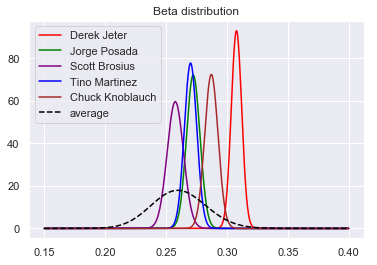

In [26]:
for player in [["Derek Jeter", "red"], 
               ["Jorge Posada", "green"], 
               ["Scott Brosius", "purple"],
               ["Tino Martinez", "blue"],
               ["Chuck Knoblauch", "brown"]]:
    x = np.linspace(0.15,0.4,1000)
    alpha = batting.loc[batting["name"] == player[0]]["alpha_1"]
    beta = batting.loc[batting["name"] == player[0]]["beta_1"]

    pdf_fitted = st.beta.pdf(x,a=alpha,b=beta)
    plt.plot(x,pdf_fitted,'-', color=player[1], label=player[0])

plt.plot(x, st.beta.pdf(x,a=alpha_0,b=beta_0), "--", color="black", label="average")
plt.title('Beta distribution')
plt.legend()
plt.show()

Let's do the asme with `seaborn`:

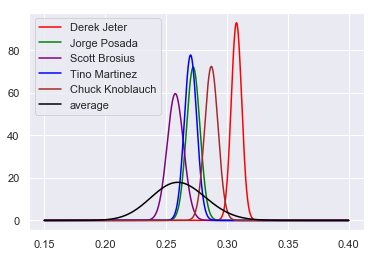

In [25]:
for player in [["Derek Jeter", "red"], 
               ["Jorge Posada", "green"], 
               ["Scott Brosius", "purple"],
               ["Tino Martinez", "blue"],
               ["Chuck Knoblauch", "brown"]]:
    x = np.linspace(0.15,0.4,1000)
    alpha = batting.loc[batting["name"] == player[0]]["alpha_1"]
    beta = batting.loc[batting["name"] == player[0]]["beta_1"]

    pdf_fitted = st.beta.pdf(x,a=alpha,b=beta)
    sn.lineplot(x,pdf_fitted, color=player[1], label=player[0])

sn.lineplot(x, st.beta.pdf(x,a=alpha_0,b=beta_0), color="black", label="average")

Let's add the 2.5%ile and 97.5%tile:

In [27]:
batting["low"] = st.beta.ppf(0.025,a=batting["alpha_1"],b=batting["beta_1"])
batting["high"] = st.beta.ppf(0.975,a=batting["alpha_1"],b=batting["beta_1"])

In [29]:
batting.loc[batting.name.isin(["Derek Jeter", "Scott Brosius", "Chuck Knoblauch"])]

,playerID,AB,H,average,name,eb_estimate,alpha_1,beta_1,low,high
1005,brosisc01,3889,1001,0.257393,Scott Brosius,0.257709,1102.4,3175.3,0.244712,0.270920
4285,jeterde01,11195,3465,0.309513,Derek Jeter,0.307881,3566.4,8017.3,0.299507,0.316318
4693,knoblch01,6366,1839,0.288878,Chuck Knoblauch,0.287267,1940.4,4814.3,0.276537,0.298116
